In [1]:
!pip install seaborn pandas

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd
import seaborn as sns

2024-02-15 03:32:47.503044: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 03:32:47.503108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 03:32:47.504424: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 03:32:47.512609: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data_dir = pathlib.Path('data').with_suffix('')

In [4]:
data = 'data'

paths = [path.parts[-2:] for path in
         pathlib.Path(data).rglob('*.*')]                             #writing purpose ('*.*') so that all image formats can be retrieved
df = pd.DataFrame(data=paths, columns=['Class','Images'])     #create column names for dataframe
df = df.sort_values('Class',ascending=True)                   #sort class name
df.reset_index(drop=True, inplace=True)                       #sort index of each row
df                                                            #display dataframe

,Class,Images
0,Cellulitis,Cellulities2.jpg
1,Cellulitis,Cellulities18.jpg
2,Cellulitis,Cellulities15.jpg
3,Cellulitis,Cellulities32.jpg
4,Cellulitis,Cellulities12.jpg
...,...,...
495,ringworm,ringworm24.jpg
496,ringworm,ringworm23.jpg
497,ringworm,ringworm16.jpg
498,ringworm,ringworm10.jpg


In [5]:
print('Count the number of image datasets')
print("Image Count : {}".format(len(df.Images)))
print("Class Count : {} \n".format(len(df['Class'].value_counts())))
print('Count the number of images in each class')
print(df['Class'].value_counts())

Count the number of image datasets
Image Count : 500
Class Count : 10 

Count the number of images in each class
Class
Cellulitis    50
Chickenpox    50
Dermatitis    50
Eczema        50
Hives         50
Lupus         50
Melanoma      50
Psoriasis     50
Vitiligo      50
ringworm      50
Name: count, dtype: int64


Text(0, 0.5, 'Count Image')

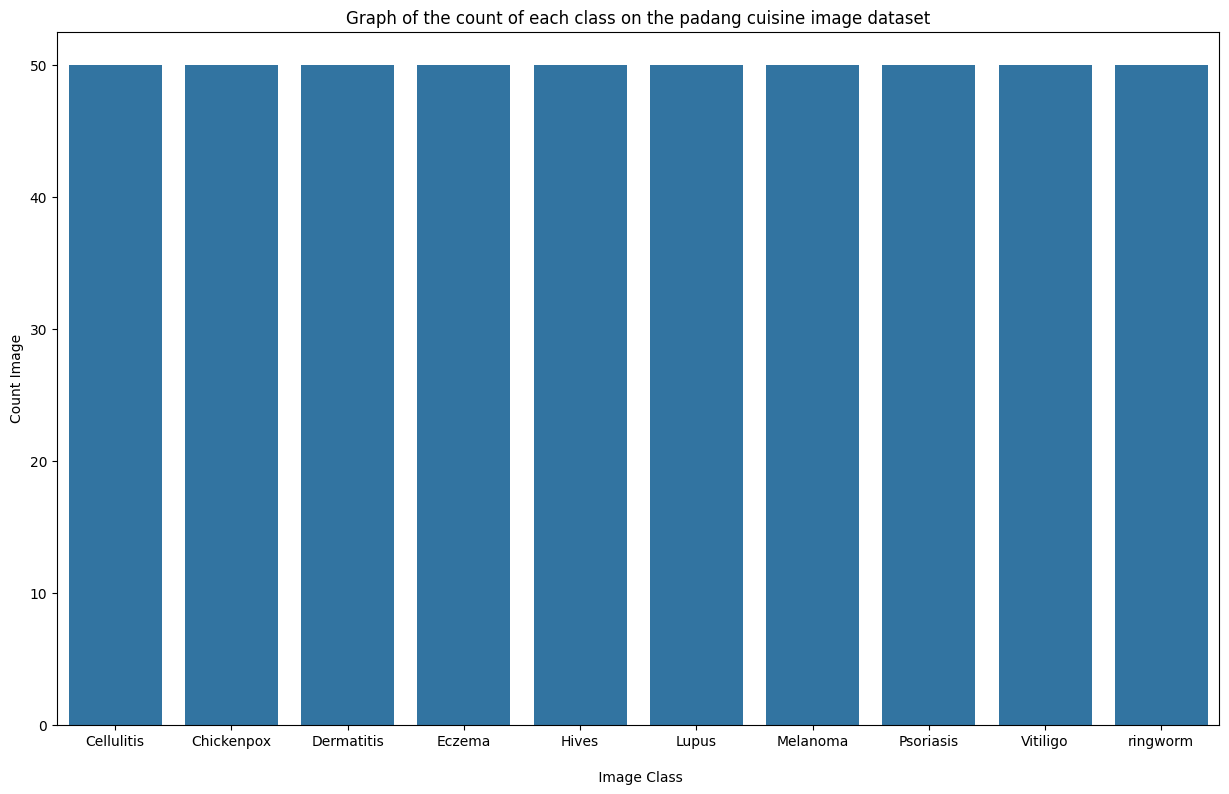

In [6]:
fig, ax = plt.subplots(figsize=(15,9))
sns.countplot(data=df, x='Class')
plt.title('Graph of the count of each class on the padang cuisine image dataset')
plt.xlabel('\n Image Class')
plt.ylabel('Count Image')

We have a good distribution of images, no over- or underepresentation of any of the classes.

In [7]:
image_count = len(list(data_dir.glob('*/*.jpeg'))) # folder/name <- */*
print(image_count)

68


In [8]:
batch_size = 16
img_height = 128
img_width = 128

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 10 classes.
Using 400 files for training.


2024-02-15 03:32:50.086251: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 03:32:50.094118: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 03:32:50.094405: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(  #the tf terminology for this method demands the term validation where we we might otherwise use the term test. Just know that validation in this case means test, we're not doing a 3-way split of the data nor k-fold cross-validation
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 10 classes.
Using 100 files for validation.


Let's see if we have all the classes represented in both the training and the test set.

In [11]:
class_names_train = train_ds.class_names
print(class_names_train)

['Cellulitis', 'Chickenpox', 'Dermatitis', 'Eczema', 'Hives', 'Lupus', 'Melanoma', 'Psoriasis', 'Vitiligo', 'ringworm']


In [12]:
class_names_test = val_ds.class_names
print(class_names_test)

['Cellulitis', 'Chickenpox', 'Dermatitis', 'Eczema', 'Hives', 'Lupus', 'Melanoma', 'Psoriasis', 'Vitiligo', 'ringworm']


In [13]:
#Scaling the data - part of EDA
normalization_layer = layers.Rescaling(1./255)

In [14]:
#begin with a custom Keras model, as per the tutorial on the tensorflow website pertaining to image classification:
num_classes = len(class_names_train)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


2024-02-15 03:32:52.214493: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-02-15 03:32:53.589295: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fba2477e2e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 03:32:53.589345: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-02-15 03:32:53.598123: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707967973.712474   61394 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 9s 95ms/step - loss: 2.3276 - accuracy: 0.1525 - val_loss: 1.9892 - val_accuracy: 0.1800
Epoch 2/50
25/25 [==============================] - 1s 52ms/step - loss: 1.9780 - accuracy: 0.2575 - val_loss: 1.8073 - val_accuracy: 0.3600
Epoch 3/50
25/25 [==============================] - 1s 53ms/step - loss: 1.7362 - accuracy: 0.3875 - val_loss: 1.7318 - val_accuracy: 0.4000
Epoch 4/50
25/25 [==============================] - 1s 53ms/step - loss: 1.4972 - accuracy: 0.4675 - val_loss: 1.6769 - val_accuracy: 0.5100
Epoch 5/50
25/25 [==============================] - 1s 54ms/step - loss: 1.2823 - accuracy: 0.5325 - val_loss: 1.6488 - val_accuracy: 0.4800
Epoch 6/50
25/25 [==============================] - 1s 54ms/step - loss: 0.9815 - accuracy: 0.6775 - val_loss: 1.9628 - val_accuracy: 0.4500
Epoch 7/50
25/25 [==============================] - 1s 53ms/step - loss: 0.7874 - accuracy: 0.7475 - val_loss: 2.1717 - val_accuracy: 0.4800
Epoch 8/50
25/25 [======

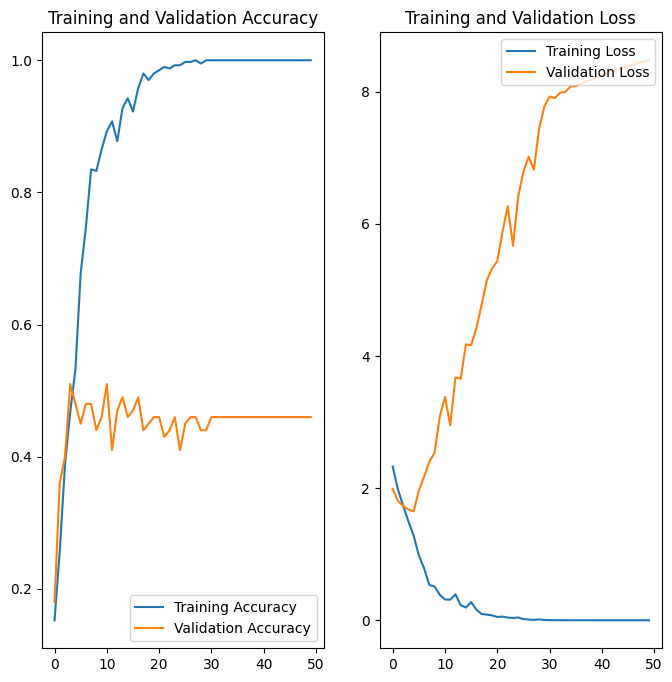

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model_alexnet=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')  
    
    
])

In [19]:
model_alexnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.001),
    metrics=['accuracy']    
)
#model.summary()

In [20]:
history_alexnet=model_alexnet.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    validation_freq=1
)

Epoch 1/50
25/25 [==============================] - 11s 99ms/step - loss: 3.3173 - accuracy: 0.1475 - val_loss: 5.5391 - val_accuracy: 0.0800
Epoch 2/50
25/25 [==============================] - 2s 64ms/step - loss: 2.6703 - accuracy: 0.2200 - val_loss: 4.3056 - val_accuracy: 0.0700
Epoch 3/50
25/25 [==============================] - 2s 65ms/step - loss: 2.4474 - accuracy: 0.2550 - val_loss: 3.6686 - val_accuracy: 0.1100
Epoch 4/50
25/25 [==============================] - 2s 65ms/step - loss: 2.1940 - accuracy: 0.3150 - val_loss: 3.2360 - val_accuracy: 0.1100
Epoch 5/50
25/25 [==============================] - 2s 65ms/step - loss: 1.9510 - accuracy: 0.3600 - val_loss: 2.5707 - val_accuracy: 0.1800
Epoch 6/50
25/25 [==============================] - 2s 65ms/step - loss: 1.8682 - accuracy: 0.3625 - val_loss: 2.0257 - val_accuracy: 0.2700
Epoch 7/50
25/25 [==============================] - 2s 65ms/step - loss: 1.7421 - accuracy: 0.4125 - val_loss: 1.8810 - val_accuracy: 0.3000
Epoch 8/50
2

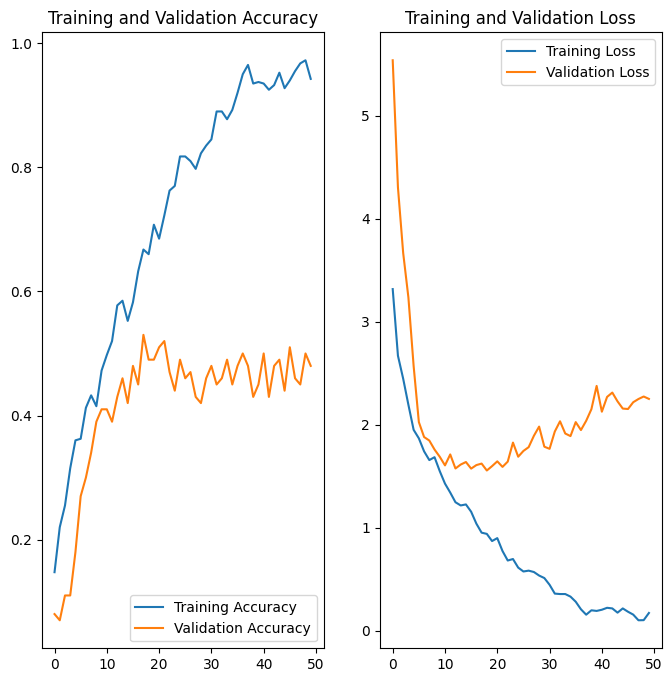

In [21]:
acc = history_alexnet.history['accuracy']
val_acc = history_alexnet.history['val_accuracy']

loss = history_alexnet.history['loss']
val_loss = history_alexnet.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()